In [1]:
#import models
import numpy as np
import h5py
import sys, os
import rospy
import rosbag
import math
from scipy.interpolate import interp1d
import h5py
import matplotlib.pylab as plt
import time 

In [2]:
#parameters of processing
frequency = 30 #Hz
bag_file_name = '../data/bags/dataset_ENVTACT_new2.bag'#'/home/hussain/me/projects/tactile/data/dataset_ENVTACT_new2.bag'
time_window_size = 6
examples_per_edge = 1

bag_file = rosbag.Bag(bag_file_name)


In [3]:
events = []
contact_status = []
contact_status_ts = []
contact_case = [] #0:No contact 1: center, 2:remainder of contacts as in list_of_rotations
contact_case_ts = []
contact_angle = []

contact_case_updated = []
contact_case_updated_ts = []

event_packet_size = []
event_packet_size_ts = []
contact_angle = []


#generate labels
possible_angle = [0.0174532925, 0.034906585, 0.0523598776, 0.075, 0.095, 0.115, 0.135, 0.15]#
N_examples = 17
list_of_rotations = [[0, 0, 0]]

for i in range(1, N_examples):
    theta = i * 2 * math.pi/(N_examples - 1)
    for phi in possible_angle:
        rx = phi * math.cos(theta)
        ry = phi * math.sin(theta)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

print(len(list_of_rotations))
print(list_of_rotations)

129
[[0, 0, 0], [0.016124739715682745, 0.006679085879971878, 0], [0.03224947943136549, 0.013358171759943756, 0], [0.048374219239436196, 0.02003725767818398, 0], [0.06929096493834651, 0.02870125742738173, 0], [0.08776855558857224, 0.03635492607468353, 0], [0.10624614623879798, 0.044008594721985324, 0], [0.12472373688902372, 0.05166226336928712, 0], [0.13858192987669302, 0.05740251485476346, 0], [0.01234134148078231, 0.012341341480782309, 0], [0.02468268296156462, 0.024682682961564617, 0], [0.03702402451305761, 0.037024024513057606, 0], [0.053033008588991064, 0.05303300858899106, 0], [0.06717514421272203, 0.06717514421272201, 0], [0.08131727983645297, 0.08131727983645295, 0], [0.09545941546018392, 0.09545941546018391, 0], [0.10606601717798213, 0.10606601717798211, 0], [0.006679085879971879, 0.016124739715682745, 0], [0.013358171759943758, 0.03224947943136549, 0], [0.020037257678183984, 0.048374219239436196, 0], [0.028701257427381735, 0.06929096493834651, 0], [0.03635492607468353, 0.08776

In [4]:
from tqdm.auto import tqdm
for topic, msg, t in tqdm(bag_file.read_messages(topics=['/contact_status', '/dvs/events', '/contact_angle'])):
    if topic == '/dvs/events':
        for e in msg.events:
            event = [e.x, e.y, e.ts.to_nsec(), e.polarity]
            events.append(event)
    elif topic == '/contact_status':
        contact_status.append(msg.data)
        contact_status_ts.append(t.to_nsec())
    elif topic == '/contact_angle':
        contact_angle.append([msg.x, msg.y, msg.z])
        
        # Updated contact status according to no. of events
        
            
#print(events)
bag_file.close()

0it [00:00, ?it/s]

In [ ]:
case_span = 2.66e9
find_ts_idx = lambda ts: np.searchsorted(contact_status_ts, ts)

def look_ahead_big(ts, idx_ts):
    fin_ts = ts + case_span
    fin_idx = find_ts_idx(fin_ts)
    print(fin_idx)
    if contact_status[fin_idx]:
        #look further
        more = True
        fin_idx_ = fin_idx 
        while more:
            fin_idx_ += 1
            if fin_idx_ - fin_idx > 25:
                print('warning more than 25 idx away from init_ts + case_span')
            if contact_status[fin_idx_]:
                continue
            else:
                more = False
        print(f'was before case ended by {fin_idx_ - fin_idx} indexes')
        fin_idx = fin_idx_ - 1
    else:
        #look backwards
        more = True
        fin_idx_ = fin_idx 
        while more:
            fin_idx_ -= 1
            if not contact_status[fin_idx_]:
                continue
            else:
                more = False
        print(f'was ahead case ended by {fin_idx - fin_idx} indexes')
        fin_idx = fin_idx_ + 1
        
    return contact_status_ts[fin_idx]


def find_case(ts):
    idx = find_ts_idx(ts)
    best_rot_diff = 100
    best_rot_idx = 1
    i = 1
    x, y, z = contact_angle[idx]
    for rot in list_of_rotations:
        diff_vals = np.sqrt(np.power(rot[0] - x, 2) +  np.power(rot[1] - y, 2) + np.power(rot[2] - z, 2))
        if best_rot_diff > diff_vals:
            best_rot_diff = diff_vals
            best_rot_idx = i
        i = i + 1
    return best_rot_idx


i = 0 
cases_ts = []
cases_idx = []
cases = []
while i < len(contact_status):
    if contact_status[i]:
        init_ts = contact_status_ts[i]
        fin_ts = look_ahead_big(init_ts, i)
        fin_idx = find_ts_idx(fin_ts)
        case = find_case(np.mean([init_ts, fin_ts]))
        
        cases.append(case)
        cases_ts.append([init_ts, fin_ts])
        cases_idx.append([i, fin_idx])
        print(len(cases_ts), init_ts, fin_ts, (fin_ts - init_ts)*1e-9, i, fin_idx, case, '\n')
        i = fin_idx + 1
    else:
        i += 1

416
was ahead case ended by 0 indexes
1 1662378738268597072 1662378740888466220 2.6198691480000003 282 413 1 

663
was before case ended by 3 indexes
2 1662378743228413369 1662378745928494229 2.7000808600000004 530 665 1 

885
was ahead case ended by 0 indexes
3 1662378748308327497 1662378750836139442 2.5278119450000003 784 877 1 

1136
was ahead case ended by 0 indexes
4 1662378753308512546 1662378755868273794 2.559761248 1002 1130 1 

1383
was before case ended by 1 indexes
5 1662378758251080543 1662378760928476102 2.6773955590000003 1249 1383 1 

1585
was ahead case ended by 0 indexes
6 1662378762308217783 1662378764868165283 2.5599475000000003 1452 1580 2 

1834
was ahead case ended by 0 indexes
7 1662378767268328555 1662378769948127249 2.679798694 1700 1834 2 

2084
was before case ended by 1 indexes
8 1662378772268509465 1662378774948096529 2.679587064 1950 2084 2 

2334
was before case ended by 1 indexes
9 1662378777268214868 1662378779948277480 2.680062612 2200 2334 2 

2588
wa

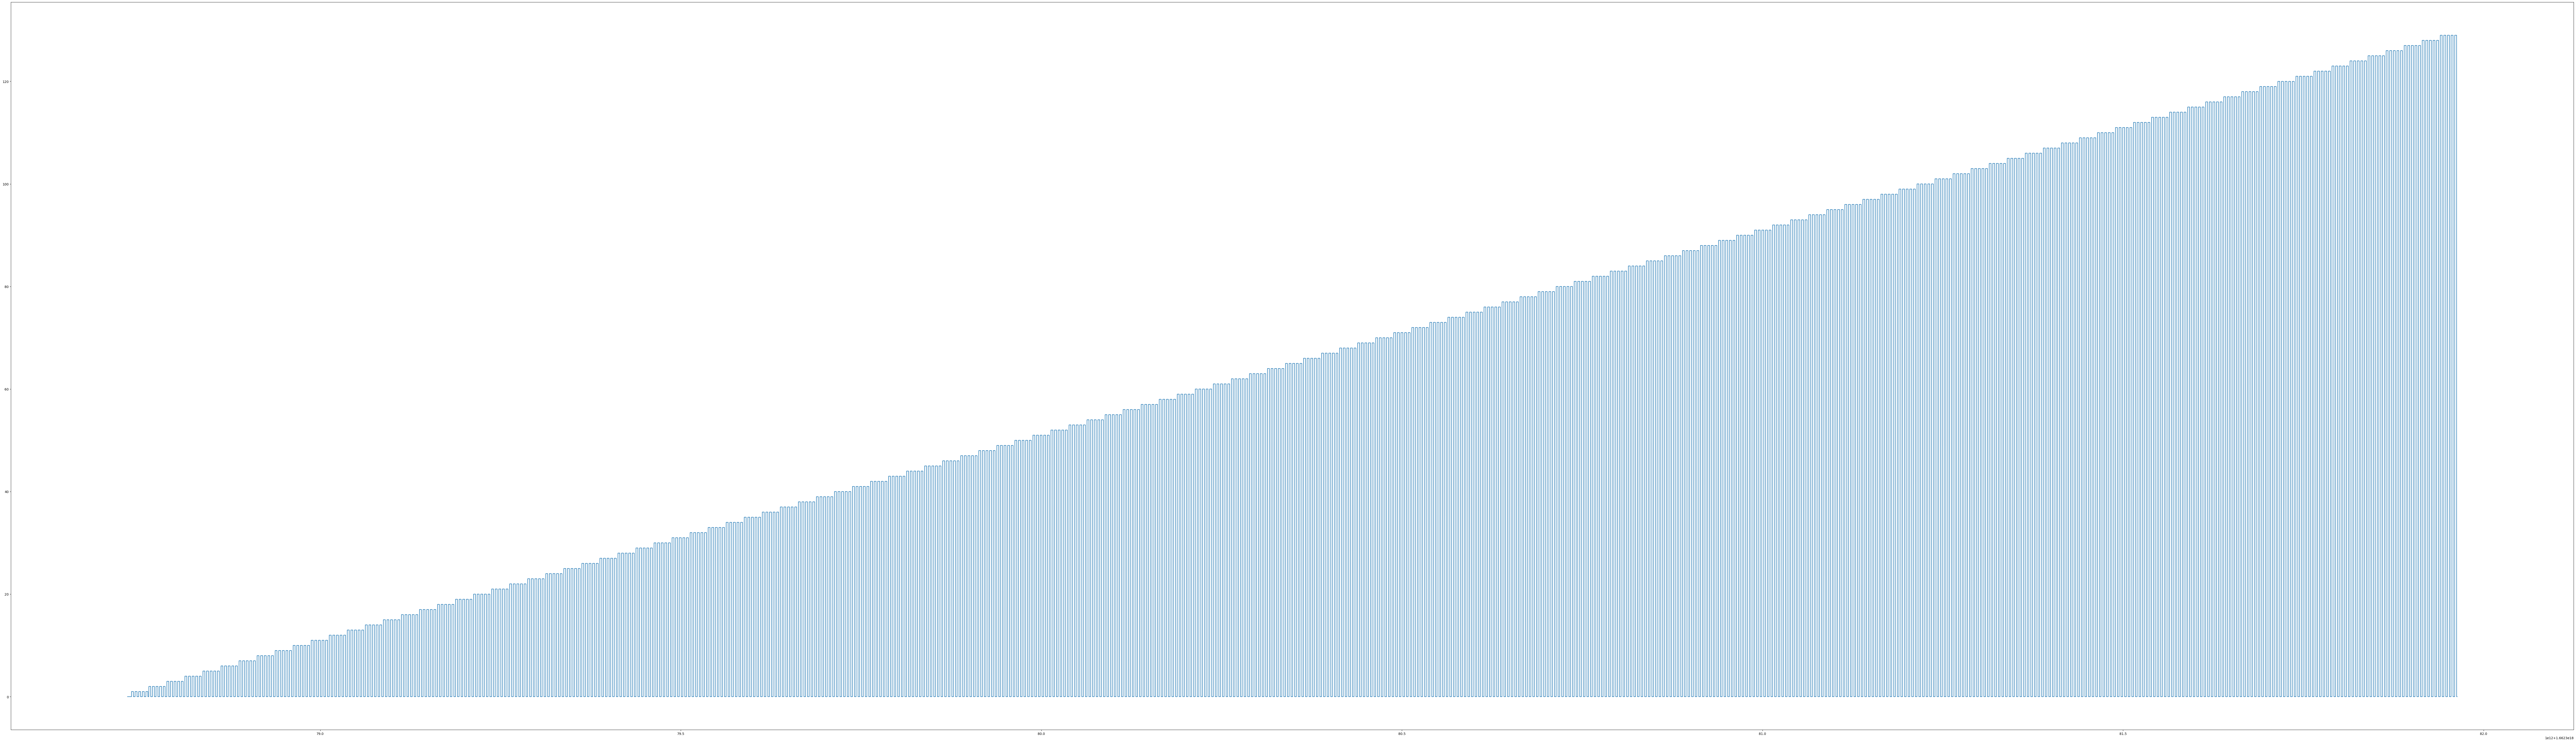

In [ ]:
contact_case = np.zeros(len(contact_status))
for i, case in enumerate(cases):
    contact_case[cases_idx[i][0]:cases_idx[i][1] + 1] = case
    
plt.figure(figsize=(140, 40))
plt.plot(contact_status_ts, contact_case)

In [ ]:
f_case = interp1d(contact_status_ts, contact_case, kind='previous')
contact_case_ts_int = np.arange(min(contact_status_ts), max(contact_status_ts), int(1e9/frequency))

contact_case_int = f_case(contact_case_ts_int)

In [ ]:
def find_interp_idx(ts):
    return np.where(ts - contact_case_ts_int < 0)[0][0]

In [ ]:
cases_int_idx = []

for i, case_ts in enumerate(cases_ts):
    case_int_idx = list(map(find_interp_idx, case_ts))
    cases_int_idx.append(case_int_idx)

In [ ]:
events=  np.array(events)
ts = events[:, 2]

In [ ]:
hist, bin_edges = np.histogram(ts, bins=int(1e7))

In [ ]:
(ts[-1] - ts[0])*1e-4

324021974.1

In [ ]:
3240219.741*1e-9

0.003240219741

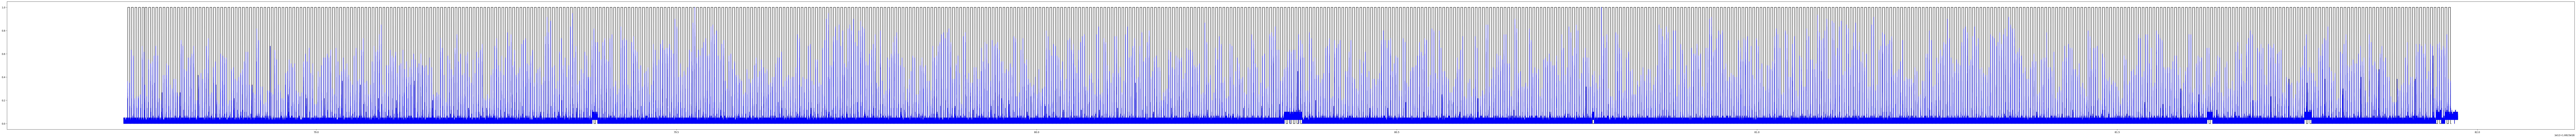

In [ ]:
plt.figure(figsize=(200, 10))
plt.plot(contact_case_ts_int, contact_case_int > 0, color='black')
plt.plot(bin_edges[:-1], (hist - hist.min()) / (hist.max() - hist.min()), c='blue')


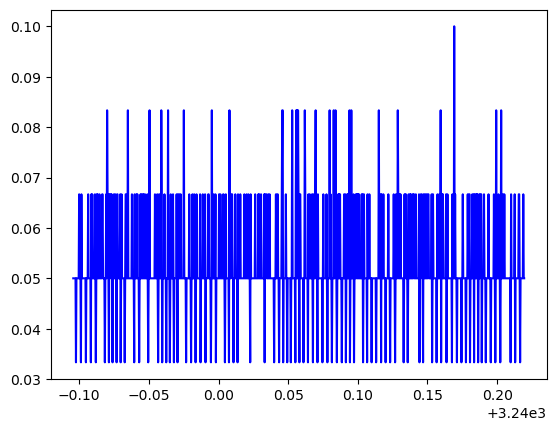

In [23]:
x = (bin_edges[:-1] - 1662378732593736638)*1e-9
y = (hist - hist.min()) / (hist.max() - hist.min())
plt.plot(x[-1000:], y[-1000:], c='blue')


In [52]:
1/45

0.022222222222222223

In [24]:
ts

array([1662378732593736638, 1662378732595119638, 1662378732595269638, ...,
       1662381972813252638, 1662381972813365638, 1662381972813477638])

In [37]:
x[-1] - x[-600]

19408916224.0

In [41]:
19408916224.0e-9/(60)

0.32348193706666667

In [43]:
(x - 1662378732593736638)[-1]

3240187338752.0

In [48]:
(3240187338752.0*1e-9 - 3000)/60

4.00312231253334

In [15]:
delta_t = 0.025e9
margin = -0.025e9
dist_from_center = lambda x, y: np.sqrt((x - 173)**2 + (y - 130)**2)
circle_rad=90

event_arrays = []
label_contact_case = []

for i, idx in enumerate(tqdm(cases_idx)):
    init_ts_idx = np.searchsorted(ts, cases_ts[i][0] + margin)
    fin_ts_idx = np.searchsorted(ts, cases_ts[i][0] + delta_t)
    if fin_ts_idx - init_ts_idx + 1 < 200:
        continue
    elif fin_ts_idx - init_ts_idx + 1 >= 2000:
        event_array = events[init_ts_idx:fin_ts_idx+1][-2001:]
        
    else:
        event_array = events[init_ts_idx:fin_ts_idx+1]
        
    in_circle = dist_from_center(event_array[:, 0], event_array[:, 1]) < circle_rad  
    event_arrays.append(event_array[in_circle, :])
    label_contact_case.append(cases[i])

  0%|          | 0/645 [00:00<?, ?it/s]

In [23]:
label_contact_case[13]

3

In [19]:
event_arrays[13]

array([[                159,                 192, 1662378802283083638,
                          0],
       [                140,                 120, 1662378802283123638,
                          1],
       [                179,                 149, 1662378802283146638,
                          1],
       ...,
       [                116,                  81, 1662378802332972638,
                          0],
       [                219,                  95, 1662378802332980638,
                          1],
       [                135,                  69, 1662378802333049638,
                          0]])

In [21]:
cases_dict = {i+1: list_of_rotations[i][:2] for i in range(len(list_of_rotations))}
cases_dict[0] = [0, 0]

In [24]:
cases_dict[3]

[0.03224947943136549, 0.013358171759943756]

In [34]:
np.searchsorted(contact_status_ts, 1662378802283146638)

3451

In [35]:
contact_angle[3451]

[0.03214987659868039, 0.013037204227675871, -5.2528432043255144e-05]

In [38]:
def rotate_case(ev_arr, label, angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    
    centered = ev_arr[:, :2] - np.array([157, 124])
    rot_ev = (R @ centered.T).T + np.array([157, 124])
    
    rot_v = np.array(cases_dict[label])
    new_rot_v = R @ rot_v
    #print(new_rot_v, cases_dict[label])

    best_rot_diff = 100
    best_rot_idx = 1
    i = 1
    
    for rot in list_of_rotations:
        diff_vals = np.sqrt( np.power(rot[0] - new_rot_v[0], 2) +  np.power(rot[1] - new_rot_v[1], 2))
        if best_rot_diff > diff_vals:
            best_rot_diff = diff_vals
            best_rot_idx = i
        i = i + 1
    
    return best_rot_idx, np.concatenate([rot_ev.astype(int), ev_arr[:, 2:]], -1)

rotate_case(event_arrays[13], label_contact_case[13], 180)

(67,
 array([[                155,                  56, 1662378802283083638,
                           0],
        [                174,                 128, 1662378802283123638,
                           1],
        [                135,                  99, 1662378802283146638,
                           1],
        ...,
        [                198,                 167, 1662378802332972638,
                           0],
        [                 95,                 153, 1662378802332980638,
                           1],
        [                179,                 179, 1662378802333049638,
                           0]]))

In [39]:
cases_dict[67]

[-0.032249479431365496, -0.013358171759943752]

In [41]:
new_lab, new_ev_arr = rotate_case(event_arrays[13], label_contact_case[13], 180)

(1569, 4)


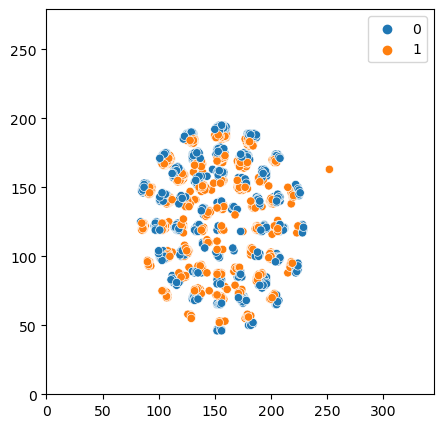

In [45]:
import seaborn as sns
def plot(ev):
    plt.figure(figsize=(5, 5))
    print(ev.shape)
    plt.xlim((0, 345))
    plt.ylim((0, 279))
    sns.scatterplot( x=ev[:, 0],y=ev[:, 1], hue=ev[:, 3])
    # sns.scatterplot(x=ev[:, 0], y=ev[:, 1], hue=ev[:, 3])
plot(event_arrays[13])

(1569, 4)


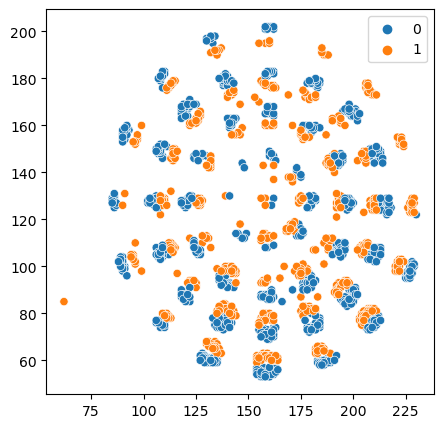

In [42]:
plot(new_ev_arr)

In [17]:
plt.figure(figsize=(10 , 10))
case = 1
all_ = cases_idx[5*case:5*case + 5]
init = all_[0][0]
final = all_[-1][1] 

<Figure size 1000x1000 with 0 Axes>

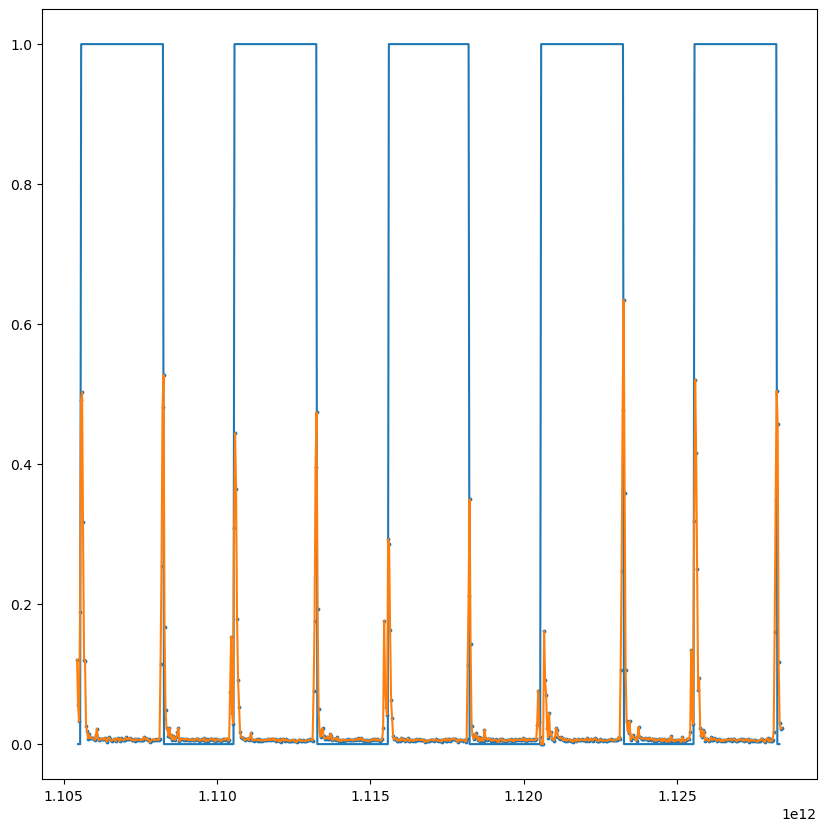

In [18]:
def plot_case(case):
    plt.figure(figsize=(10 , 10))
    idx = np.where(np.array(cases) == case)[0]
    all_ = np.array(cases_int_idx)[idx]
    init = all_[0][0] -3 
    final = all_[-1][1] + 3
    
    plt.plot(contact_case_ts_int[init:final]-contact_case_ts_int[0], contact_case_int[init:final] / (case))
    
    
    init_events = np.searchsorted(bin_edges, np.array(cases_ts)[idx][0][0]) - 5
    final_events = np.searchsorted(bin_edges, np.array(cases_ts)[idx][-1][1])+ 5
    
    plt.plot(bin_edges[init_events:final_events] - bin_edges[0], hist[init_events:final_events] / hist.max())
    plt.scatter(bin_edges[init_events:final_events] - bin_edges[0], hist[init_events:final_events] / hist.max(), s=3)
    #print(hist.max())
    
    
    
plot_case(45)

In [19]:
n_events_case = np.array([len(a) for a in event_arrays])
len(n_events_case)

644

In [20]:
np.sort(n_events_case)[:10]

array([239, 243, 399, 431, 459, 470, 487, 500, 518, 523])

In [21]:
np.argsort(n_events_case)[:10]

array([ 52,  14,   9,  82,  88, 333,  38,  25,   2, 100])

In [22]:
means = []
mins = []
maxs = []
for i in range(1, 129):
    idx= np.where(np.array(label_contact_case) == i)[0]
    sort = np.sort(n_events_case[idx])
    means.append(np.mean(sort))
    print(i,  len(idx), np.mean(sort), sort)

1 5 1304.4 [ 518  561 1713 1843 1887]
2 5 1353.2 [ 399  773 1849 1858 1887]
3 5 1365.6 [ 243 1247 1569 1881 1888]
4 5 1631.8 [ 626 1874 1881 1886 1892]
5 5 1618.6 [1012 1529 1809 1846 1897]
6 5 1376.8 [ 500  711 1880 1884 1909]
7 5 1707.4 [1155 1686 1878 1908 1910]
8 5 1189.6 [ 487 1068 1137 1404 1852]
9 5 1233.2 [ 584  772 1121 1814 1875]
10 5 1447.0 [ 645  977 1866 1871 1876]
11 5 1524.6 [ 239 1751 1867 1879 1887]
12 5 1725.2 [1110 1872 1872 1879 1893]
13 5 1788.8 [1628 1672 1872 1881 1891]
14 5 1688.6 [1157 1575 1894 1901 1916]
15 5 1645.6 [ 729 1863 1870 1871 1895]
16 5 1888.8 [1881 1883 1888 1895 1897]
17 5 1549.2 [ 431 1653 1852 1888 1922]
18 5 1150.8 [ 459  540 1021 1856 1878]
19 5 1872.0 [1863 1868 1875 1875 1879]
20 5 1414.6 [ 567 1147 1646 1840 1873]
21 5 1581.6 [ 523 1704 1888 1889 1904]
22 5 1816.8 [1637 1842 1861 1872 1872]
23 5 1778.6 [1340 1877 1888 1889 1899]
24 5 1610.6 [ 940 1449 1872 1888 1904]
25 5 1893.0 [1881 1886 1891 1894 1913]
26 5 1690.0 [1474 1495 1760 1853 1

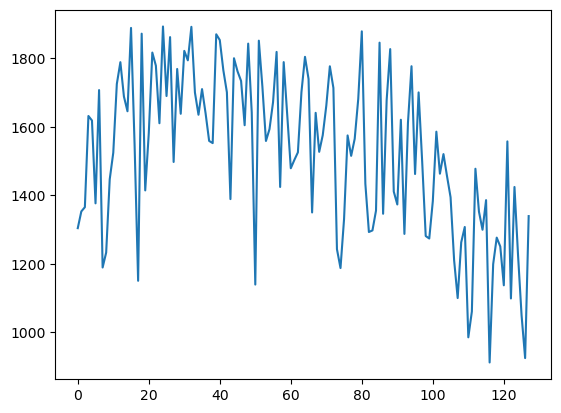

In [23]:
plt.plot(means)

Text(0.5, 0, 'mean # events per angle of contact')

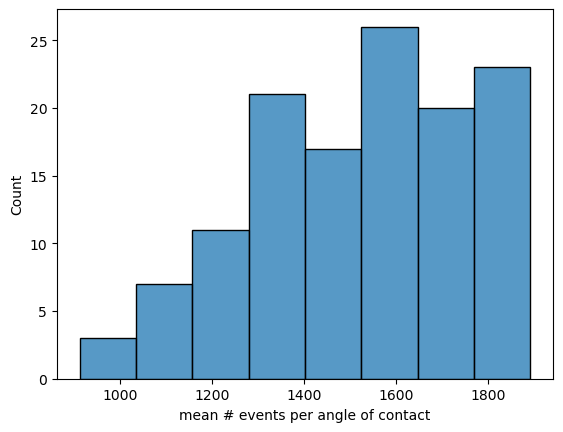

In [24]:
sns.histplot(means)
plt.xlabel('mean # events per angle of contact')

In [25]:
event_array[:, :2]

array([[320, 143],
       [153, 192],
       [123, 160],
       ...,
       [188, 121],
       [130, 169],
       [154, 201]])

In [26]:
event_array

array([[                320,                 143, 1662381960001151638,
                          1],
       [                153,                 192, 1662381960001161638,
                          0],
       [                123,                 160, 1662381960001164638,
                          1],
       ...,
       [                188,                 121, 1662381960050857638,
                          1],
       [                130,                 169, 1662381960050866638,
                          0],
       [                154,                 201, 1662381960050948638,
                          0]])

(2001, 4)


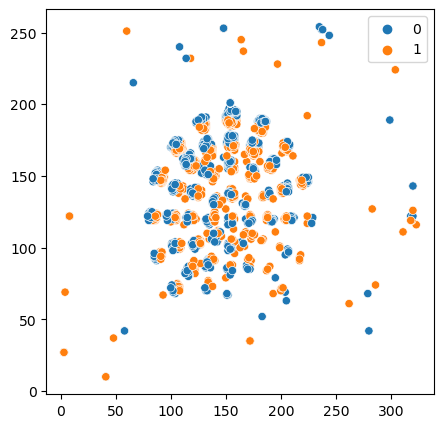

In [27]:
plot(event_array)

In [28]:
plot(rotate_case(event_array, 0, 90))

NameError: name 'rotate_case' is not defined

In [ ]:
cases_dict[21]

In [ ]:
label_contact_case[100]

In [ ]:
cases_dict = {i+1: list_of_rotations[i][:2] for i in range(len(list_of_rotations))}
cases_dict[0] = [0, 0]

In [ ]:
def rotate_case(ev_arr, label, angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    
    centered = ev_arr[:, :2] - np.array([345, 259]) / 2
    rot_ev = (R @ centered.T).T + np.array([345, 259]) / 2
    
    rot_v = np.array(cases_dict[label])
    new_rot_v = R @ rot_v
    print(new_rot_v, cases_dict[label])

    best_rot_diff = 100
    best_rot_idx = 1
    i = 1
    
    for rot in list_of_rotations:
        diff_vals = np.sqrt( np.power(rot[0] - new_rot_v[0], 2) +  np.power(rot[1] - new_rot_v[1], 2))
        if best_rot_diff > diff_vals:
            best_rot_diff = diff_vals
            best_rot_idx = i
        i = i + 1
    
    
    return best_rot_idx, np.concatenate([rot_ev.astype(int), ev_arr[:, 2:]], -1)

In [ ]:
def augmented_generator():
    for case, event_array in zip(label_contact_case, event_arrays):
        for angle in [0, 90, 180, 270]:
            if angle == 0:
                yield case, event_array
            else:
                yield rotate_case(event_array, case, angle)

In [ ]:
samples={}

for i, (case, event_array) in enumerate(augmented_generator()):
    rotated = []
    samples[f'sample_{i+1}'] = {
        'events': event_array.tolist(),
        'case': case
        }

In [ ]:
from sklearn.model_selection import train_test_split
from pathlib import Path
import json

outdir = Path('/home/hussain/tactile/data/contact_extraction6')

sample_idx = list(samples.keys())

train_idx, val_test_idx = train_test_split(sample_idx, test_size=0.4, random_state=0) #fixed across extractions
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=0) #fixed across extractions

params = {}


subsets = zip(['train', 'test', 'val'], [train_idx, val_idx, test_idx])

for sub_name, subset in subsets:
    if not (outdir / sub_name).exists():
        (outdir / sub_name / 'raw').mkdir(parents=True)
        (outdir / sub_name / 'processed').mkdir(parents=True)

        with open(outdir / sub_name / 'extraction_params.json', 'w') as f:
            json.dump(params, f, indent=4)

    with open(outdir / sub_name / 'raw' / 'contact_cases.json', 'w') as f:
        subset_samples = {}
        for i, subset_idx in enumerate(subset):
            sample = samples[subset_idx]
            sample['total_idx'] = subset_idx
            subset_samples[f'sample_{i+1}'] = sample
        json.dump(subset_samples, f, indent=4)

In [ ]:
samples

In [ ]:
from imports.TactileDataset import TactileDataset

TactileDataset('/home/hussain/tactile/data/contact_extraction6/train/')

In [ ]:
0.6*644*4

In [35]:
def events_plot_3d(events_data):
    events_data[:,2] = (events_data[:,2] - events_data[0,2]).astype(float) / 1e9
    events_positive = events_data[events_data[:,3]==1, 0:3]
    events_negative = events_data[events_data[:,3]==0, 0:3]

    # Visualize events in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    px_pos = events_positive[:,0]
    py_pos = events_positive[:,1]
    t_st_pos = events_positive[:,2]
    ax.scatter(px_pos, py_pos, t_st_pos, c="red", s=5, marker='.')
    px_neg = events_negative[:,0]
    py_neg = events_negative[:,1]
    t_st_neg = events_negative[:,2]
    ax.scatter(px_neg, py_neg, t_st_neg, c="blue", s=5, marker='.')
    plt.show()


In [36]:
event_arrays[0]

array([[                127,                  88, 1662378738243607638,
                          1],
       [                168,                 129, 1662378738243613638,
                          1],
       [                106,                  74, 1662378738243616638,
                          1],
       ...,
       [                108,                 110, 1662378738293444638,
                          1],
       [                151,                  47, 1662378738293514638,
                          0],
       [                223,                  89, 1662378738293601638,
                          0]])

In [38]:
event_arrays[0]

array([[127,  88,   0,   1],
       [168, 129,   0,   1],
       [106,  74,   0,   1],
       ...,
       [108, 110,   0,   1],
       [151,  47,   0,   0],
       [223,  89,   0,   0]])

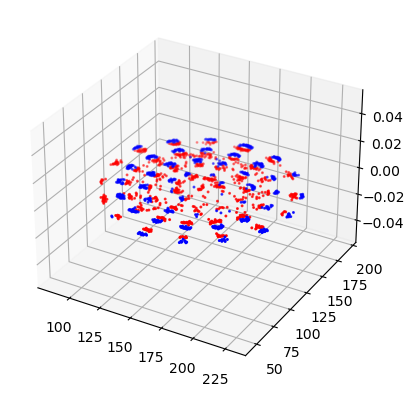

In [37]:
events_plot_3d(event_arrays[0])